In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/data-without-drift/test_clean.csv
/kaggle/input/data-without-drift/train_clean.csv


In [2]:
# imports
%matplotlib inline

import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import numba
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, f1_score, plot_confusion_matrix
from keras import Sequential 
from keras.layers import Dense, Dropout
from keras.optimizers import Adam 
from keras.utils import to_categorical
import torch 
import lightgbm as lgb
import gc 

Using TensorFlow backend.


# Load data
Thanks to https://www.kaggle.com/cdeotte/data-without-drift.

In [3]:
#Memory reduction function
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [44]:
# read data
data = pd.read_csv('../input/data-without-drift/train_clean.csv')
data_test = pd.read_csv('../input/data-without-drift/test_clean.csv')
data.head()

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


# Feature engineering
Add to signal several other signals: gradients, rolling mean, std, low/high pass filters...

FE is the same as this notebook https://www.kaggle.com/martxelo/fe-and-simple-mlp with corrections in filters.

In [5]:
def calc_gradients(s, n_grads=4):
    '''
    Calculate gradients for a pandas series. Returns the same number of samples
    '''
    grads = pd.DataFrame()
    
    g = s.values
    for i in range(n_grads):
        g = np.gradient(g)
        grads['grad_' + str(i+1)] = g
        
    return grads

In [6]:
def calc_low_pass(s, n_filts=10):
    '''
    Applies low pass filters to the signal. Left delayed and no delayed
    '''
    wns = np.logspace(-2, -0.3, n_filts)
    
    low_pass = pd.DataFrame()
    x = s.values
    for wn in wns:
        b, a = signal.butter(1, Wn=wn, btype='low')
        zi = signal.lfilter_zi(b, a)
        low_pass['lowpass_lf_' + str('%.4f' %wn)] = signal.lfilter(b, a, x, zi=zi*x[0])[0]
        low_pass['lowpass_ff_' + str('%.4f' %wn)] = signal.filtfilt(b, a, x)
        
    return low_pass

In [7]:
def calc_high_pass(s, n_filts=10):
    '''
    Applies high pass filters to the signal. Left delayed and no delayed
    '''
    wns = np.logspace(-2, -0.1, n_filts)
    
    high_pass = pd.DataFrame()
    x = s.values
    for wn in wns:
        b, a = signal.butter(1, Wn=wn, btype='high')
        zi = signal.lfilter_zi(b, a)
        high_pass['highpass_lf_' + str('%.4f' %wn)] = signal.lfilter(b, a, x, zi=zi*x[0])[0]
        high_pass['highpass_ff_' + str('%.4f' %wn)] = signal.filtfilt(b, a, x)
        
    return high_pass

In [8]:
def calc_roll_stats(s, windows=[10, 25, 50, 100, 250, 500]):
    '''
    Calculates rolling stats like mean, std, min, max...
    '''
    roll_stats = pd.DataFrame()
    for w in windows:
        roll_stats['roll_mean_' + str(w)] = s.rolling(window=w, min_periods=1).mean()
        roll_stats['roll_std_' + str(w)] = s.rolling(window=w, min_periods=1).std()
        roll_stats['roll_min_' + str(w)] = s.rolling(window=w, min_periods=1).min()
        roll_stats['roll_max_' + str(w)] = s.rolling(window=w, min_periods=1).max()
        roll_stats['roll_range_' + str(w)] = roll_stats['roll_max_' + str(w)] - roll_stats['roll_min_' + str(w)]
        roll_stats['roll_q10_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.10)
        roll_stats['roll_q25_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.25)
        roll_stats['roll_q50_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.50)
        roll_stats['roll_q75_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.75)
        roll_stats['roll_q90_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.90)
    
    # add zeros when na values (std)
    roll_stats = roll_stats.fillna(value=0)
             
    return roll_stats

In [9]:
def calc_ewm(s, windows=[10, 25, 50, 100, 250, 500]):
    '''
    Calculates exponential weighted functions
    '''
    ewm = pd.DataFrame()
    for w in windows:
        ewm['ewm_mean_' + str(w)] = s.ewm(span=w, min_periods=1).mean()
        ewm['ewm_std_' + str(w)] = s.ewm(span=w, min_periods=1).std()
        
    # add zeros when na values (std)
    ewm = ewm.fillna(value=0)
        
    return ewm

In [10]:
def add_features(s):
    '''
    All calculations together
    '''
    
    gradients = calc_gradients(s)
    low_pass = calc_low_pass(s)
    high_pass = calc_high_pass(s)
    roll_stats = calc_roll_stats(s)
    ewm = calc_ewm(s)
    
    return pd.concat([s, gradients, low_pass, high_pass, roll_stats, ewm], axis=1)


def divide_and_add_features(s, signal_size=500000):
    '''
    Divide the signal in bags of "signal_size".
    Normalize the data dividing it by 15.0
    '''
    # normalize
    s = s/15.0
    
    ls = []
    for i in tqdm(range(int(s.shape[0]/signal_size))):
        sig = s[i*signal_size:(i+1)*signal_size].copy().reset_index(drop=True)
        sig_featured = add_features(sig)
        ls.append(sig_featured)
    
    return pd.concat(ls, axis=0)

In [11]:
# apply every feature to data
df = divide_and_add_features(data['signal'])
df_test = divide_and_add_features(data_test['signal'])

df = reduce_mem_usage(df)
df_test = reduce_mem_usage(df_test)

del data_test 
gc.collect()

100%|██████████| 4/4 [00:44<00:00, 11.07s/it]


Memory usage of dataframe is 4501.34 MB
Memory usage after optimization is: 1153.95 MB
Decreased by 74.4%
Memory usage of dataframe is 1800.54 MB
Memory usage after optimization is: 461.58 MB
Decreased by 74.4%


22

Let's plot the signals to see how they look like.

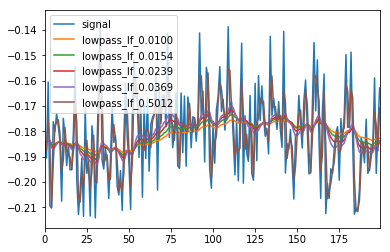

In [12]:
# The low pass lfilter captures the trend of the signal for different cutoff frequencies
df[['signal',
    'lowpass_lf_0.0100',
    'lowpass_lf_0.0154',
    'lowpass_lf_0.0239',
    'lowpass_lf_0.0369',
    'lowpass_lf_0.5012']].iloc[:200].plot()

In [ ]:
# The low pass filtfilt captures the trend of the signal for different cutoff frequencies
# but without delay
df[['signal',
    'lowpass_ff_0.0100',
    'lowpass_ff_0.0154',
    'lowpass_ff_0.0239',
    'lowpass_ff_0.0369',
    'lowpass_ff_0.5012']].iloc[:200].plot()

In [ ]:
# The high pass lfilter captures fast variation of the signal for different cutoff frequencies
df[['signal',
    'highpass_lf_0.0100',
    'highpass_lf_0.0163',
    'highpass_lf_0.0264',
    'highpass_lf_0.3005',
    'highpass_lf_0.7943']].iloc[:100].plot()

In [ ]:
# The high pass lfilter captures fast variation of the signal for different cutoff frequencies
# but without delay
df[['signal',
    'highpass_ff_0.0100',
    'highpass_ff_0.0163',
    'highpass_ff_0.0264',
    'highpass_ff_0.3005',
    'highpass_ff_0.7943']].iloc[:200].plot()

In [ ]:
# rolling mean, quantiles and ewm also capture the trend
df[['signal',
    'roll_mean_10',
    'roll_mean_50',
    'roll_mean_100',
    'roll_q50_100',
    'ewm_mean_10',
    'ewm_mean_50',
    'ewm_mean_100']].iloc[:100].plot()

In [ ]:
# quantiles, min, max
df[['signal',
    'roll_min_100',
    'roll_q10_100',
    'roll_q25_100',
    'roll_q50_100',
    'roll_q75_100',
    'roll_q90_100',
    'roll_max_100']].iloc[:1000].plot()

In [ ]:
# rolling std, and emw std
df[['signal',
    'roll_std_10',
    'roll_std_50',
    'ewm_std_10',
    'ewm_std_50']].iloc[:100].plot()

# Divide in train and test

In [17]:
#Extract train and test samples 
X_train = df.values
y_train = data['open_channels'].values
X_test = df_test.values

# Classes weights

In [13]:
#Function to be used during kfold training 
def get_class_weight(classes, exp=1):
    '''
    Weight of the class is inversely proportional to the population of the class.
    There is an exponent for adding more weight.
    '''
    hist, _ = np.histogram(classes, bins=np.arange(12)-0.5)
    class_weight = hist.sum()/np.power(hist, exp)
    
    return class_weight


#lr-scheduler function 
LR = 0.001
EPOCHS = 10

def epoch_lr_reduction(epoch):
    for i in range(epoch):
        if epoch % i == 0:
            lr = LR/2 
        else:
            lr = LR
    return lr 


adam = Adam(lr=LR)
# class_weight = get_class_weight(y_train)
# print('class_weight=', class_weight)
# plt.figure()
# plt.title('classes')
# plt.hist(y_train, bins=np.arange(12)-0.5)
# plt.figure()
# plt.title('class_weight')
# plt.bar(np.arange(11), class_weight)
# plt.title('class_weight')

# Build a MLP model

In [ ]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier 

rf = RandomForestClassifier(n_estimators=300, warm_start=True, max_depth=5, min_samples_leaf=2, n_jobs=-1)
et = ExtraTreesClassifier(n_estimators=300, max_depth=6, min_samples_leaf=2, n_jobs=-1)
ada = AdaBoostClassifier(n_estimators=500, learning_rate=0.01)
gbc = GradientBoostingClassifier(learning_rate=0.01, n_estimators=300, subsample=1.0, max_depth=5, warm_start=True)
bc = BaggingClassifier(n_estimators=300, bootstrap=True, bootstrap_features=True, warm_start=True, n_jobs=-1)

Defining the base learner networks 

In [14]:
def network_1(xtrain, ytrain, xtest, oos, cw):
    '''
    Returns a keras model
    '''
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=xtrain.shape[1]))
    model.add(Dense(100))
    model.add(Dense(11, activation='softmax'))
    model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    
    model.fit(xtrain, ytrain, epochs=10, batch_size=5000, class_weight=cw, 
             verbose=2)
    prediction = model.predict(xtest) #Prediction on the kfold sample 
    oof_prediction = model.predict(oos) #Prediction on the test set
    return prediction, oof_prediction 


def network_2(xtrain, ytrain, xtest, oos, cw):
    
    model = Sequential()
    model.add(Dense(250, input_dim=xtrain.shape[1], kernel_initializer='random_uniform', activation='relu'))
    model.add(Dense(200))
    model.add(Dense(150, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(11, activation='softmax'))
    model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    
    model.fit(xtrain, ytrain, epochs=EPOCHS, batch_size=10000, class_weight=cw, verbose=2)
    prediction = model.predict(xtest)
    oof_prediction = model.predict(oos)
    return prediction, oof_prediction 

def network_3(xtrain, ytrain, xtest, oos, cw):
    
    model = Sequential()
    model.add(Dense(125, input_dim=xtrain.shape[1], kernel_initializer='random_normal', activation='relu'))
    model.add(Dense(150, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(150, activation='relu'))
    model.add(Dense(100))
    model.add(Dense(11, activation='softmax'))
    model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    
    model.fit(xtrain, ytrain, epochs=EPOCHS, batch_size=20000, class_weight=cw, verbose=2)
    prediction = model.predict(xtest)
    oof_prediction = model.predict(oos)
    return prediction, oof_prediction 
    
def network_4(xtrain, ytrain, xtest, oos, cw):
    
    model = Sequential()
    model.add(Dense(200, activation='tanh', input_dim=xtrain.shape[1], kernel_initializer='random_normal'))
    model.add(Dense(150, activation='tanh'))
    model.add(Dense(200, activation='tanh'))
    model.add(Dense(11, activation='softmax'))
              
    model.compile(optimizer=Adam(lr=0.01), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    
    model.fit(xtrain, ytrain, epochs=EPOCHS, batch_size=25000, class_weight=cw, verbose=2)
    prediction = model.predict(xtest)
    oof_prediction = model.predict(oos)
    return prediction, oof_prediction 
              
def network_5(xtrain, ytrain, xtest, oos, cw):
    
    model = Sequential()
    model.add(Dense(250, input_dim=xtrain.shape[1]))
    model.add(Dense(125))
    model.add(Dropout(0.3))
    model.add(Dense(200))
    model.add(Dense(125))
    model.add(Dropout(0.25))
    model.add(Dense(11, activation='softmax'))
    model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    
    model.fit(xtrain, ytrain, epochs=EPOCHS, batch_size=10000, class_weight=cw, verbose=2)
    prediction = model.predict(xtest)
    oof_prediction = model.predict(oos)
    return prediction, oof_prediction 
    

#### Base strategy is to train the models on 5-Kfold and train each fold on a different partition

In [ ]:
# class StackedEnsemble:
    
#     def __init__(self, model, x_train, y_train, x_test):
#         self.x_train = x_train 
#         self.y_train = y_train 
#         self.x_test = x_test 
        
#         self.ntrain = self.X_train.shape[0]
#         self.ntest = self.X_test.shape[0]
#         self.NFOLDS = 5 
#         self.SEED = 50
        
#         self.oof_train = np.zeros((self.ntrain,))
#         self.oof_test = np.zeros((self.ntest,))
#         self.oof_test_sampled = np.empty((self.))

In [15]:
from scipy.stats import mode

class StackedNet:
    
    def __init__(self, X_train, y_train, X_test):
        self.X_train = X_train 
        self.y_train = y_train 
        self.X_test = X_test 
        
        self.ntrain = self.X_train.shape[0]
        self.ntest = self.X_test.shape[0]
        self.NFOLDS = 5 
        self.SEED = 42
        
        self.oof_train = np.zeros((self.ntrain,))
        self.oof_test = np.zeros((self.ntest,))
        self.oof_test_sampled = np.empty((self.ntest, 5))
    
    def fit_model(self, model):
        kf = KFold(n_splits=self.NFOLDS, random_state=self.SEED)
        
        for i, (train_index, test_index) in enumerate(kf.split(self.X_train, self.y_train)):
            X_tr, y_tr = self.X_train[train_index], self.y_train[train_index]
            X_te = self.X_train[test_index]
            
            class_weight = get_class_weight(y_tr)
            
            print(f'Model name: {model}')
            print(f'Fitting model for fold {i+1}\n')
            preds, oof_preds = model(X_tr, y_tr, X_te, self.X_test, class_weight)
            preds = np.argmax(preds, axis=-1)
            oof_preds = np.argmax(oof_preds, axis=-1)

            self.oof_train[test_index] = preds
            self.oof_test_sampled[:, i] = oof_preds
            print('Model processing complete..\n')
            
            del preds, oof_preds 
            gc.collect()
            
        self.oof_test = mode(self.oof_test_sampled, axis=1)[0].reshape(1, -1)[0]
        return self.oof_train, self.oof_test      
            
# ntrain = X_train.shape[0]
# ntest = X_test.shape[0]
# NFOLDS = 5 #5fold validation 
# SEED = 42
# kf = KFold(n_splits=NFOLDS, random_state=SEED)

# # def base_learners(model, xtrain, ytrain, xtest):
# oof_train = np.zeros((ntrain,))
# oof_test = np.zeros((ntest,))
# oof_test_sampled = np.empty((NFOLDS, ntest))


# def base_learners(model, xtrain, ytrain, xtest)
# for i, (train_index, test_index) in enumerate(kf.split(xtrain, ytrain)):
    

In [18]:
#Generating base-learner train samples 
snet = StackedNet(X_train, y_train, X_test)

#Get the base-learner train samples from the initial nets
m1_train, m1_test = snet.fit_model(network_1)
m2_train, m2_test = snet.fit_model(network_2)
m3_train, m3_test = snet.fit_model(network_3)
m4_train, m4_test = snet.fit_model(network_4)
m5_train, m5_test = snet.fit_model(network_5)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Model name: <function network_1 at 0x7f001c580488>
Fitting model for fold 1

Epoch 1/10
 - 9s - loss: 0.3725 - sparse_categorical_accuracy: 0.8884
Epoch 2/10
 - 8s - loss: 0.1291 - sparse_categorical_accuracy: 0.9533
Epoch 3/10
 - 8s - loss: 0.1170 - sparse_categorical_accuracy: 0.9562
Epoch 4/10
 - 8s - loss: 0.1129 - sparse_categorical_accuracy: 0.9573
Epoch 5/10
 - 8s - loss: 0.1112 - sparse_categorical_accuracy: 0.9577
Epoch 6/10
 - 8s - loss: 0.1102 - sparse_categorical_accuracy: 0.9579
Epoch 7/10
 - 8s - loss: 0.1095 - sparse_categorical_accuracy: 0.9581
Epoch 8/10
 - 8s - loss: 0.1089 - sparse_categorical_accuracy: 0.9583
Epoch 9/10
 - 8s - loss: 0.1085 - sparse_categorical_accuracy: 0.9583
Epoch 10/10
 - 8s - loss: 0.1081 - sparse_categorical_accuracy: 0.9585
Model processing complete..

Model name: <function network_1 at 0x7f001c580488>
Fitting model for fold 2

Epoch 1/10
 - 8s - loss: 0.2024 - sparse_categorical_accuracy: 0.9335
Epoch 2/10
 - 8s - loss: 0.1140 - sparse_categ

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Model name: <function network_2 at 0x7f001c5802f0>
Fitting model for fold 1

Epoch 1/10
 - 8s - loss: 0.3520 - sparse_categorical_accuracy: 0.8835
Epoch 2/10
 - 7s - loss: 0.1263 - sparse_categorical_accuracy: 0.9539
Epoch 3/10
 - 8s - loss: 0.1197 - sparse_categorical_accuracy: 0.9559
Epoch 4/10
 - 7s - loss: 0.1171 - sparse_categorical_accuracy: 0.9565
Epoch 5/10
 - 7s - loss: 0.1159 - sparse_categorical_accuracy: 0.9568
Epoch 6/10
 - 7s - loss: 0.1144 - sparse_categorical_accuracy: 0.9572
Epoch 7/10
 - 8s - loss: 0.1135 - sparse_categorical_accuracy: 0.9573
Epoch 8/10
 - 7s - loss: 0.1132 - sparse_categorical_accuracy: 0.9574
Epoch 9/10
 - 7s - loss: 0.1127 - sparse_categorical_accuracy: 0.9575
Epoch 10/10
 - 7s - loss: 0.1122 - sparse_categorical_accuracy: 0.9576
Model processing complete..

Model name: <function network_2 at 0x7f001c5802f0>
Fitting model for fold 2

Epoch 1/10
 - 8s - loss: 0.3551 - sparse_categorical_accuracy: 0.8784
Epoch 2/10
 - 8s - loss: 0.1217 - sparse_categ

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Model name: <function network_3 at 0x7f001c5800d0>
Fitting model for fold 1

Epoch 1/10
 - 7s - loss: 0.3089 - sparse_categorical_accuracy: 0.8920
Epoch 2/10
 - 7s - loss: 0.1238 - sparse_categorical_accuracy: 0.9538
Epoch 3/10
 - 7s - loss: 0.1190 - sparse_categorical_accuracy: 0.9553
Epoch 4/10
 - 7s - loss: 0.1168 - sparse_categorical_accuracy: 0.9560
Epoch 5/10
 - 7s - loss: 0.1152 - sparse_categorical_accuracy: 0.9566
Epoch 6/10
 - 7s - loss: 0.1141 - sparse_categorical_accuracy: 0.9569
Epoch 7/10
 - 7s - loss: 0.1133 - sparse_categorical_accuracy: 0.9573
Epoch 8/10
 - 7s - loss: 0.1127 - sparse_categorical_accuracy: 0.9574
Epoch 9/10
 - 7s - loss: 0.1126 - sparse_categorical_accuracy: 0.9573
Epoch 10/10
 - 7s - loss: 0.1118 - sparse_categorical_accuracy: 0.9577
Model processing complete..

Model name: <function network_3 at 0x7f001c5800d0>
Fitting model for fold 2

Epoch 1/10
 - 7s - loss: 0.3145 - sparse_categorical_accuracy: 0.8888
Epoch 2/10
 - 7s - loss: 0.1214 - sparse_categ

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Model name: <function network_4 at 0x7f001c580510>
Fitting model for fold 1

Epoch 1/10
 - 7s - loss: 0.3533 - sparse_categorical_accuracy: 0.8809
Epoch 2/10
 - 7s - loss: 0.1177 - sparse_categorical_accuracy: 0.9560
Epoch 3/10
 - 7s - loss: 0.1129 - sparse_categorical_accuracy: 0.9570
Epoch 4/10
 - 7s - loss: 0.1120 - sparse_categorical_accuracy: 0.9570
Epoch 5/10
 - 7s - loss: 0.1107 - sparse_categorical_accuracy: 0.9574
Epoch 6/10
 - 7s - loss: 0.1103 - sparse_categorical_accuracy: 0.9574
Epoch 7/10
 - 7s - loss: 0.1091 - sparse_categorical_accuracy: 0.9578
Epoch 8/10
 - 7s - loss: 0.1090 - sparse_categorical_accuracy: 0.9577
Epoch 9/10
 - 7s - loss: 0.1090 - sparse_categorical_accuracy: 0.9578
Epoch 10/10
 - 7s - loss: 0.1089 - sparse_categorical_accuracy: 0.9577
Model processing complete..

Model name: <function network_4 at 0x7f001c580510>
Fitting model for fold 2

Epoch 1/10
 - 7s - loss: 0.3320 - sparse_categorical_accuracy: 0.8845
Epoch 2/10
 - 7s - loss: 0.1179 - sparse_categ

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Model name: <function network_5 at 0x7f001c580598>
Fitting model for fold 1

Epoch 1/10
 - 9s - loss: 0.4856 - sparse_categorical_accuracy: 0.8375
Epoch 2/10
 - 8s - loss: 0.3077 - sparse_categorical_accuracy: 0.9107
Epoch 3/10
 - 8s - loss: 0.2937 - sparse_categorical_accuracy: 0.9158
Epoch 4/10
 - 8s - loss: 0.2866 - sparse_categorical_accuracy: 0.9185
Epoch 5/10
 - 8s - loss: 0.2823 - sparse_categorical_accuracy: 0.9199
Epoch 6/10
 - 8s - loss: 0.2799 - sparse_categorical_accuracy: 0.9208
Epoch 7/10
 - 8s - loss: 0.2771 - sparse_categorical_accuracy: 0.9217
Epoch 8/10
 - 8s - loss: 0.2754 - sparse_categorical_accuracy: 0.9224
Epoch 9/10
 - 8s - loss: 0.2741 - sparse_categorical_accuracy: 0.9228
Epoch 10/10
 - 8s - loss: 0.2727 - sparse_categorical_accuracy: 0.9232
Model processing complete..

Model name: <function network_5 at 0x7f001c580598>
Fitting model for fold 2

Epoch 1/10
 - 8s - loss: 0.4751 - sparse_categorical_accuracy: 0.8324
Epoch 2/10
 - 8s - loss: 0.2841 - sparse_categ

In [19]:
#Create training dataframe 
stack_train = pd.DataFrame({'Network_1':m1_train.ravel(),
                           'Network_2': m2_train.ravel(),
                           'Network_3': m3_train.ravel(),
                           'Network_4': m4_train.ravel(),
                           'Network_5': m5_train.ravel()})

stack_test = pd.DataFrame({'Network_1': m1_test.ravel(),
                          'Network_2': m2_test.ravel(),
                          'Network_3': m3_test.ravel(),
                          'Network_4': m4_test.ravel(),
                          'Network_5': m5_test.ravel()})

In [20]:
stack_train

,Network_1,Network_2,Network_3,Network_4,Network_5
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
4999995,7.0,7.0,7.0,7.0,7.0
4999996,7.0,7.0,7.0,7.0,7.0
4999997,8.0,8.0,8.0,8.0,8.0
4999998,9.0,9.0,9.0,9.0,9.0


In [21]:
stack_test

,Network_1,Network_2,Network_3,Network_4,Network_5
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
1999995,0.0,0.0,0.0,0.0,0.0
1999996,0.0,0.0,0.0,0.0,0.0
1999997,0.0,0.0,0.0,0.0,0.0
1999998,0.0,0.0,0.0,0.0,0.0


In [ ]:
pd.Series(lol[0].reshape(1, -1)[0])

# Build LGBM model
Parameters from https://www.kaggle.com/ragnar123/single-model-lgbm. Thanks!

array([0, 0, 0, ..., 8, 9, 9])

In [39]:
from xgboost import XGBClassifier

params = {
    'objective':'multi:softmax',
    'num_classes':11,
    'max_depth':2,
    'learning_rate':0.01,
    'booster':'gbtree',
    'n_jobs':-1, 
    'gamma':0.001,
    'colsample_bytree':125000
}
# weights = get_class_weight(y_train)

xgb = XGBClassifier(params)
print('Initializing Training...')
xgb.fit(stack_train, y_train, eval_metric='merror')
print('Training complete..')

Initializing Training...
[03:03:58] WARNING: /workspace/src/gbm/gbtree.cc:138: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
Training complete..


In [40]:
prediction = xgb.predict(stack_test)

array([0, 0, 0, ..., 0, 0, 0])

In [24]:
# fit the model
print('Training LGBM...')
gbc = lgb.train(params, dataset,
                num_boost_round=1000,
                verbose_eval=100)
print('LGBM trained!')

Training LGBM...
LGBM trained!


In [29]:
# predict on test
gbc_pred = gbc.predict(stack_test)
print('gbc_pred.shape=', gbc_pred.shape)
del gbc_pred 
gc.collect()

gbc_pred.shape= (2000000,)


40

In [28]:
pd.Series(gbc_pred).value_counts()

2.467815    1220107
2.562393     217425
2.748679     135412
2.658010     116950
2.844229      80482
2.944111      55897
3.133886      55094
3.224871      47696
3.041373      36734
3.322002      26919
3.401357       7284
dtype: int64

In [ ]:
# def convert_to_one_hot(pred):
#     '''
#     Convert the prediction into probabilities
#     Example: 1.6 --> [0, 0.4, 0.6, 0, 0, ...]
#     1.6 is closer to 2 than to 1
#     All rows will sum 1
#     '''

#     # clip results lower or higher than limits
#     pred = np.clip(pred, 0, 10)

#     # convert to "one-hot"
#     pred = 1 - np.abs(pred.reshape((-1,1)) - np.arange(11))

#     # clip results lower than 0
#     pred = np.clip(pred, 0, 1)
    
#     return pred
    
# gbc_pred = convert_to_one_hot(gbc_pred)

# print('gbc_pred.shape=', gbc_pred.shape)

# Ensemble
The idea is to mix both results with a parameter alpha ($0\le\alpha\le1$):

$y_{pred}=\alpha·mlp_{pred} + (1-\alpha)·gbc_{pred}$

In [ ]:
# # lists for keep results
# f1s = []
# alphas = np.linspace(0,1,101)

# # loop for every alpha
# for alpha in tqdm(alphas):
#     y_pred = alpha*mlp_pred + (1 - alpha)*gbc_pred
#     f1 = f1_score(y_test, np.argmax(y_pred, axis=-1), average='macro')
#     f1s.append(f1)

# # convert to numpy array
# f1s = np.array(f1s)

# # get best_alpha
# best_alpha = alphas[np.argmax(f1s)]

# print('best_f1=', f1s.max())
# print('best_alpha=', best_alpha)

In [ ]:
# plt.plot(alphas, f1s)
# plt.title('f1_score for ensemble')
# plt.xlabel('alpha')
# plt.ylabel('f1_score')

# Confusion matrix

In [42]:
# # Thanks to https://www.kaggle.com/marcovasquez/basic-nlp-with-tensorflow-and-wordcloud
def plot_cm(y_true, y_pred, title):
    figsize=(16,16)
    y_pred = y_pred.astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap='viridis', annot=annot, fmt='', ax=ax)

In [ ]:
# f1_mlp = f1_score(, np.argmax(mlp_pred, axis=-1), average='macro')
plot_cm(y_, np.argmax(mlp_pred, axis=-1), 'Only MLP \n f1=' + str('%.4f' %f1_mlp))

In [ ]:
# f1_gbc = f1_score(y_test, np.argmax(gbc_pred, axis=-1), average='macro')
# plot_cm(y_test, np.argmax(gbc_pred, axis=-1), 'Only GBC \n f1=' + str('%.4f' %f1_gbc))

In [ ]:
# y_pred = best_alpha*mlp_pred + (1 - best_alpha)*gbc_pred
# f1_ens = f1_score(y_test, np.argmax(y_pred, axis=-1), average='macro')
# plot_cm(y_test, np.argmax(y_pred, axis=-1), 'Ensemble \n f1=' + str('%.4f' %f1_ens))

# Submit result

In [46]:
submission = pd.DataFrame({'time':data_test['time'], 'open_channels':prediction})

In [49]:
submission

,time,open_channels
0,500.0001,0
1,500.0002,0
2,500.0003,0
3,500.0004,0
4,500.0005,0
...,...,...
1999995,699.9996,0
1999996,699.9997,0
1999997,699.9998,0
1999998,699.9999,0


In [50]:
submission.to_csv('submission.csv',index=False, float_format='%.4f')

In [ ]:
# def submit_result(mlp, gbc, alpha):
    
#     print('Reading data...')
#     data = pd.read_csv('../input/data-without-drift/test_clean.csv')
    
#     print('Feature engineering...')
#     df = divide_and_add_features(data['signal'])
    
#     print('Predicting MLP...')
#     mlp_pred = mlp.predict(df.values)
    
#     print('Predicting GBC...')
#     gbc_pred = gbc.predict(df.values)
#     gbc_pred = convert_to_one_hot(gbc_pred)
    
#     print('Ensembling...')
#     y_pred = alpha*mlp_pred + (1 - alpha)*gbc_pred
#     y_pred = np.argmax(y_pred, axis=-1)
    
#     print('Writing submission...')
#     submission = pd.DataFrame()
#     submission['time'] = data['time']
#     submission['open_channels'] = y_pred
#     submission.to_csv('submission.csv', index=False, float_format='%.4f')
    
#     print('Submission finished!')

In [ ]:
# submit_result(mlp, gbc, best_alpha)